In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error

import lightgbm as lgb
from lightgbm import early_stopping

import warnings
warnings.filterwarnings("ignore")

In [23]:
df = pd.read_csv('data.csv')

# Data Preprocessing

In [24]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_test.drop(columns=['Premium Amount'], inplace=True)

print("Размер первой части (тренировочная выборка):", train.shape)
print("Размер второй части (тестовая выборка):", test.shape)

df_train.to_csv('train_part.csv', index=False)
df_test.to_csv('test_part.csv', index=False)

Размер первой части (тренировочная выборка): (960000, 21)
Размер второй части (тестовая выборка): (240000, 21)


In [25]:
display(df_train.head())
display(df_test.head())

# Verify shapes
print("Train Data Shape:", df_train.shape)
print("Test Data Shape:", df_test.shape)

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
404339,404339,45.0,Male,91315.0,Divorced,3.0,Bachelor's,NaN,43.926883,Urban,...,NaN,1.0,311.0,2.0,2024-08-11 15:21:39.134960,Poor,No,Rarely,House,2386.0
748487,748487,51.0,Female,5280.0,Married,1.0,PhD,NaN,41.854227,Rural,...,NaN,1.0,634.0,8.0,2020-06-20 15:21:39.098696,Poor,Yes,Monthly,Condo,285.0
435951,435951,48.0,Female,41318.0,Divorced,0.0,Master's,NaN,51.750192,Urban,...,1.0,12.0,759.0,9.0,2021-02-05 15:21:39.134960,Poor,Yes,Rarely,Condo,654.0
311284,311284,43.0,Female,30372.0,Divorced,0.0,PhD,Unemployed,20.666786,Urban,...,2.0,8.0,460.0,1.0,2022-11-11 15:21:39.093681,Average,No,Monthly,Condo,1095.0
318790,318790,18.0,Male,12891.0,Married,NaN,Bachelor's,NaN,36.995102,Urban,...,NaN,18.0,831.0,3.0,2021-01-01 15:21:39.095696,Poor,Yes,Monthly,Apartment,1334.0


,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
372605,372605,52.0,Female,5538.0,Married,NaN,Master's,Employed,8.093145,Rural,Basic,0.0,18.0,497.0,3.0,2020-02-10 15:21:39.274993,Average,No,Weekly,Apartment
551204,551204,60.0,Female,39711.0,Married,4.0,Bachelor's,Employed,NaN,Suburban,Comprehensive,0.0,3.0,340.0,3.0,2020-10-16 15:21:39.097737,Poor,No,Weekly,Apartment
240320,240320,58.0,Female,2364.0,Married,2.0,Bachelor's,NaN,34.452482,Urban,Comprehensive,2.0,19.0,NaN,7.0,2021-01-02 15:21:39.126661,Poor,No,Monthly,House
1047361,1047361,39.0,Male,9094.0,Divorced,0.0,Bachelor's,NaN,26.241661,Rural,Basic,1.0,17.0,761.0,5.0,2022-05-11 15:21:39.134960,Poor,Yes,Rarely,Condo
555362,555362,47.0,Male,43189.0,Divorced,NaN,PhD,NaN,26.691921,Suburban,Comprehensive,1.0,4.0,319.0,4.0,2020-07-28 15:21:39.181605,Poor,Yes,Weekly,Apartment


Train Data Shape: (960000, 21)
Test Data Shape: (240000, 20)


In [26]:
# Display information for the training dataset
print("Training Dataset Information: \n")
train_info = df_train.info()
display(train_info)
print('\n')
# Display information for the test dataset
print("Test Dataset Information: \n")
test_info = df_test.info()
display(test_info)

Training Dataset Information: 

<class 'pandas.core.frame.DataFrame'>
Index: 960000 entries, 404339 to 121958
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    960000 non-null  int64  
 1   Age                   944952 non-null  float64
 2   Gender                960000 non-null  object 
 3   Annual Income         924086 non-null  float64
 4   Marital Status        945137 non-null  object 
 5   Number of Dependents  872136 non-null  float64
 6   Education Level       960000 non-null  object 
 7   Occupation            673379 non-null  object 
 8   Health Score          900671 non-null  float64
 9   Location              960000 non-null  object 
 10  Policy Type           960000 non-null  object 
 11  Previous Claims       668845 non-null  float64
 12  Vehicle Age           959996 non-null  float64
 13  Credit Score          849726 non-null  float64
 14  Insurance Duration  

None



Test Dataset Information: 

<class 'pandas.core.frame.DataFrame'>
Index: 240000 entries, 372605 to 423212
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    240000 non-null  int64  
 1   Age                   236343 non-null  float64
 2   Gender                240000 non-null  object 
 3   Annual Income         230965 non-null  float64
 4   Marital Status        236334 non-null  object 
 5   Number of Dependents  218192 non-null  float64
 6   Education Level       240000 non-null  object 
 7   Occupation            168546 non-null  object 
 8   Health Score          225253 non-null  float64
 9   Location              240000 non-null  object 
 10  Policy Type           240000 non-null  object 
 11  Previous Claims       167126 non-null  float64
 12  Vehicle Age           239998 non-null  float64
 13  Credit Score          212392 non-null  float64
 14  Insurance Duration    

None

In [27]:
test_ids = df_test['id']
df_train.drop(columns=['id'], inplace=True)
df_test.drop(columns=['id'], inplace=True)

In [28]:
def date_features(df):
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Year'] = df['Policy Start Date'].dt.year
    df['Month'] = df['Policy Start Date'].dt.month
    df['Day'] = df['Policy Start Date'].dt.day
    df['Day_of_Week'] = df['Policy Start Date'].dt.dayofweek

    # Cyclical features
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    
    # Drop original 'Policy Start Date'
    df.drop(columns=['Policy Start Date'], inplace=True)
    return df

df_train = date_features(df_train)
df_test = date_features(df_test)

In [29]:
def add_features(df):
    # Contract length feature based on Insurance Duration
    df['contract_length'] = pd.cut(
        df['Insurance Duration'].fillna(99),
        bins=[-float('inf'), 1, 3, float('inf')],
        labels=[0, 1, 2]
    ).astype(int)
    return df

df_train = add_features(df_train)
df_test = add_features(df_test)

In [30]:
# Function to calculate missing values and percentages
def missing_values_table(df):
    missing_count = df.isnull().sum()
    missing_percentage = 100 * missing_count / len(df)
    return pd.DataFrame({'Missing Values': missing_count, 'Percentage (%)': missing_percentage})

# Create tables for train and test datasets
train_missing_table = missing_values_table(df_train)
test_missing_table = missing_values_table(df_test)

# Display the tables
print("Missing Values Table - Training Dataset:\n")
display(train_missing_table[train_missing_table['Missing Values'] > 0])  # Display only features with missing values
print("\n")

print("Missing Values Table - Test Dataset:\n")
display(test_missing_table[test_missing_table['Missing Values'] > 0])  # Display only features with missing values

Missing Values Table - Training Dataset:



,Missing Values,Percentage (%)
Age,15048,1.567500
Annual Income,35914,3.741042
Marital Status,14863,1.548229
Number of Dependents,87864,9.152500
Occupation,286621,29.856354
Health Score,59329,6.180104
Previous Claims,291155,30.328646
Vehicle Age,4,0.000417
Credit Score,110274,11.486875
Insurance Duration,1,0.000104




Missing Values Table - Test Dataset:



,Missing Values,Percentage (%)
Age,3657,1.523750
Annual Income,9035,3.764583
Marital Status,3666,1.527500
Number of Dependents,21808,9.086667
Occupation,71454,29.772500
Health Score,14747,6.144583
Previous Claims,72874,30.364167
Vehicle Age,2,0.000833
Credit Score,27608,11.503333
Customer Feedback,15529,6.470417


In [31]:
# Separate numerical and categorical columns
numerical_cols = df_train.select_dtypes(include=['float64']).columns.drop('Premium Amount')
categorical_cols = df_train.select_dtypes(include=['object']).columns

# Impute missing numerical values with median
imputer_num = SimpleImputer(strategy='median')
df_train[numerical_cols] = imputer_num.fit_transform(df_train[numerical_cols])
df_test[numerical_cols] = imputer_num.transform(df_test[numerical_cols])

# Impute missing categorical values with mode
imputer_cat = SimpleImputer(strategy='most_frequent')
df_train[categorical_cols] = imputer_cat.fit_transform(df_train[categorical_cols])
df_test[categorical_cols] = imputer_cat.transform(df_test[categorical_cols])

In [32]:
def frequency_encode(train, test, cat_cols):
    for col in cat_cols:
        freq_encoding = train[col].value_counts().to_dict()
        train[col] = train[col].map(freq_encoding)
        test[col] = test[col].map(freq_encoding)
    return train, test

df_train, df_test = frequency_encode(df_train, df_test, categorical_cols)

In [40]:
# Log-transform skewed features
df_train['Annual Income'] = np.log1p(df_train['Annual Income'])
df_test['Annual Income'] = np.log1p(df_test['Annual Income'])

# Log-transform target variable
y = np.log1p(df_train['Premium Amount'])
X = df_train.drop(columns=['Premium Amount'])

# EDA

IndexError: index 20 is out of bounds for axis 0 with size 20

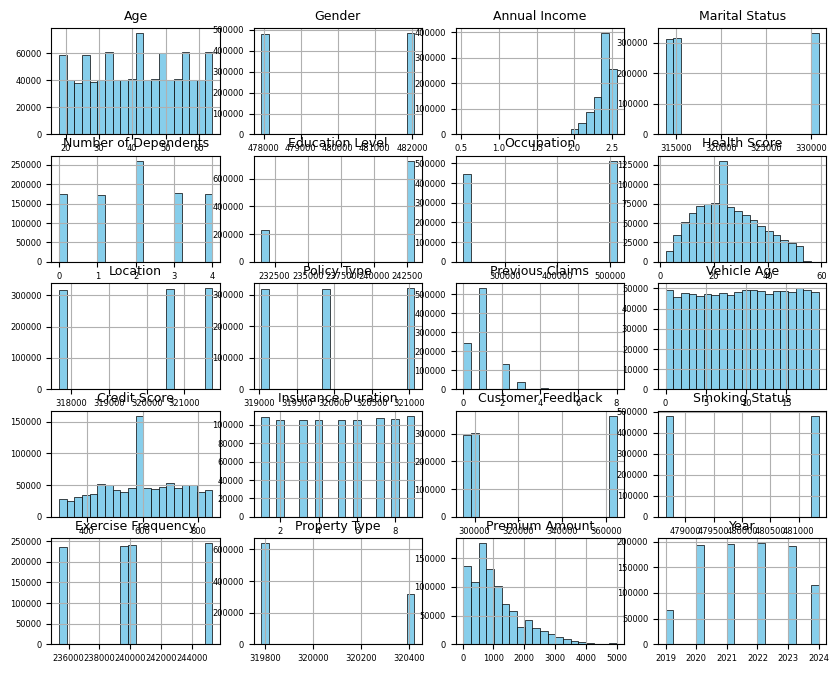

In [41]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 8))
columns_to_plot = df_train.columns
for i, column in enumerate(columns_to_plot):
    ax = axes.flatten()[i]
    df_train[column].hist(ax=ax, bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
    ax.set_title(column, fontsize=9)
    ax.tick_params(axis='both', which='major', labelsize=6)
plt.suptitle('Dataset Feature Distributions (train)', fontsize=11)
plt.tight_layout()
plt.show()

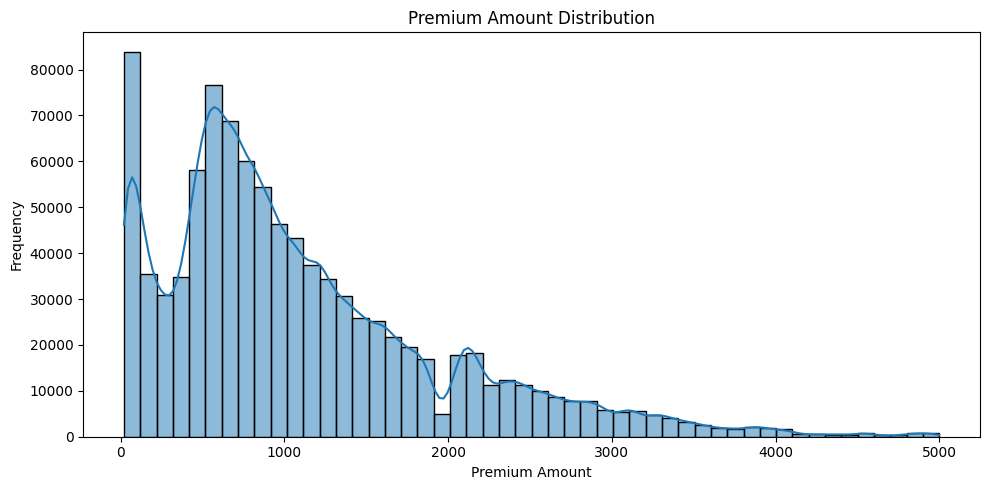

In [45]:
plt.figure(figsize=(10,5))
sns.histplot(df_train['Premium Amount'], kde=True, bins=50)
plt.title('Premium Amount Distribution')
plt.xlabel("Premium Amount")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

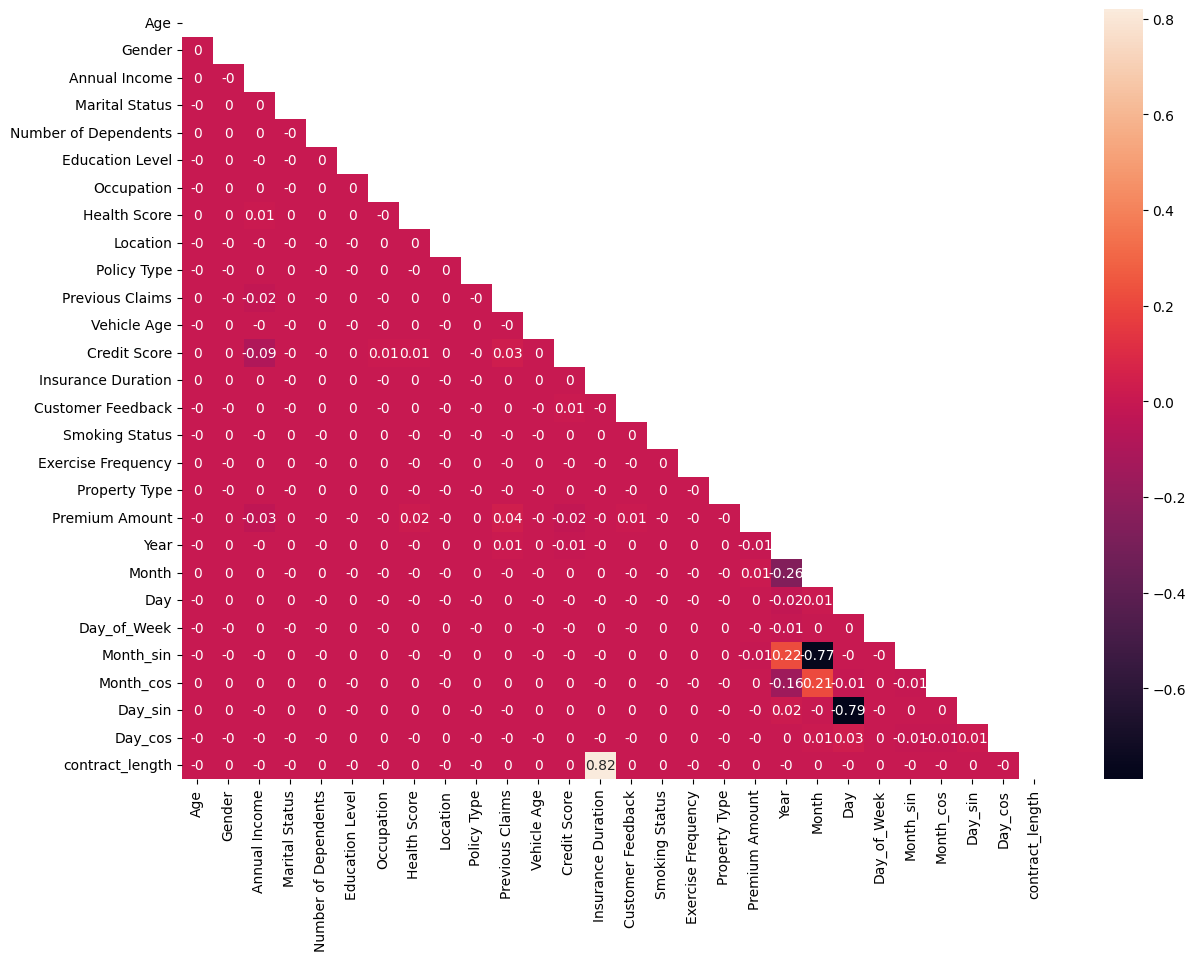

In [47]:
plt.figure(figsize=(14,10))
sns.heatmap(df_train.corr().round(2), annot=True, mask=np.triu(df_train.corr()))
plt.show()

# building model


In [34]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
lgbm_gbdt_model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=10,
    num_leaves=50,
    device='gpu',
    random_state=42
)

# Fit the model with early stopping
lgbm_gbdt_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[early_stopping(stopping_rounds=50, verbose=True)]
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1028
[LightGBM] [Info] Number of data points in the train set: 768000, number of used features: 27
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (20.51 MB) transferred to GPU in 0.019489 secs. 0 sparse feature groups
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.594865
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[126]	valid_0's l2: 1.10639


LGBMRegressor(device='gpu', learning_rate=0.05, max_depth=10, n_estimators=1000,
              num_leaves=50, random_state=42)

In [36]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [37]:
# LightGBM GBDT Cross-Validation
cv_scores_lgbm_gbdt = cross_val_score(lgbm_gbdt_model, X, y, cv=kf, scoring='neg_mean_squared_log_error')
rmsle_lgbm_gbdt = np.mean(np.sqrt(-cv_scores_lgbm_gbdt))
print(f'LightGBM GBDT RMSLE: {rmsle_lgbm_gbdt:.5f}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1029
[LightGBM] [Info] Number of data points in the train set: 768000, number of used features: 27
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (20.51 MB) transferred to GPU in 0.018635 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 6.594865
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1028
[LightGBM] [Info] Number of data points in the train set: 768000, number of used features: 27
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Ti, Vendor: NVIDIA Corp

In [38]:
# Fit the models on the full training data
lgbm_gbdt_model.fit(X, y)
# Predict on the test data

gbdt_preds = lgbm_gbdt_model.predict(df_test)
final_preds_log = gbdt_preds
final_preds = np.expm1(final_preds_log)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1029
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 27
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (25.63 MB) transferred to GPU in 0.022512 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 6.593848


In [39]:
submission = pd.DataFrame({
    'id': test_ids,
    'Premium Amount': final_preds
})

# Display the first few rows of the submission file
print(submission.head(10))


              id  Premium Amount
372605    372605      851.421908
551204    551204      940.672591
240320    240320      816.764308
1047361  1047361      740.059003
555362    555362      991.583915
1062538  1062538      522.569627
552662    552662      800.060507
1021194  1021194      705.860662
886200    886200      761.589666
609792    609792      769.085513
